In [2]:
# Importar dependencias iniciales
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [3]:
# Importar dependencias
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
# setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Agregar los directorios
path_positivos = os.path.join('data', 'positive')
path_negativos = os.path.join('data', 'negative')
path_anchos = os.path.join('data', 'anchor')

In [11]:
# Crear los directorios
os.makedirs(path_positivos)
os.makedirs(path_negativos)
os.makedirs(path_anchos)

Recolectando la data
http://vis-www.cs.umass.edu/lfw/

In [12]:
# Descomprimir el dataset
!tar -xf lfw.tgz

In [13]:
# Mover la data al directorio data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        path_lfw = os.path.join('lfw', directory, file)
        data_path = os.path.join(path_negativos, file)
        os.replace(path_lfw, data_path)

In [6]:
# Librería que genera nombres aleatorios
import uuid
os.path.join(path_anchos, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\a4b3bade-d42c-11ee-8d8a-ddd1ee8c241e.jpg'

Recolectamos las imágenes en estos dos porque vamos a verificar si es que pertenece a positivo o negativo

In [15]:
# abrir y conectar una cámara
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # Reducir la ventana a 250x250
    frame = frame[120:120+250,200:200+250, :]
    # Recolectar el ancho para data
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Crear el path para guardar la imagen
        imgname = os.path.join(path_anchos, '{}.jpg'.format(uuid.uuid1()))
        # Escribe la imagen
        cv2.imwrite(imgname, frame)

    # Recolectar positivos
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Crear el path para guardar la imagen
        imgname = os.path.join(path_positivos, '{}.jpg'.format(uuid.uuid1()))
        # Escribir la imagen
        cv2.imwrite(imgname, frame)

    # Mostrar la imagen
    cv2.imshow('Image Collection', frame)

    # Romper el bucle
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Quitar la webcam
cap.release()
# Destruir todas las ventanas
cv2.destroyAllWindows()

In [16]:
#código genérico para realizar data augmentation gracias a tensorflow
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data


In [17]:
#llamamos a cada una de las imágenes de los positivos, y hacemos por cada una un data augmentation
#EJECUTAR DESPUES
for file_name in os.listdir(os.path.join(path_positivos)):
    img_path = os.path.join(path_positivos, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)
    for image in augmented_images:
        cv2.imwrite(os.path.join(path_positivos, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [18]:
#llamamos a cada una de las imágenes de los positivos, y hacemos por cada una un data augmentation
#EJECUTAR DESPUES
for file_name in os.listdir(os.path.join(path_anchos)):
    img_path = os.path.join(path_anchos, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)
    for image in augmented_images:
        cv2.imwrite(os.path.join(path_anchos, '{}.jpg'.format(uuid.uuid1())), image.numpy())

Obtener las imágenes

In [23]:
anchor = tf.data.Dataset.list_files(path_anchos+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(path_positivos+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(path_negativos+'/*.jpg').take(3000)

In [24]:
#nos permitirá recorrer más facilmente las imágenes
dir_test = anchor.as_numpy_iterator()

In [25]:
print(dir_test.next())

b'data\\anchor\\4ffb58d8-d41e-11ee-9831-ddd1ee8c241e.jpg'


Preprocesamiento de cada imagen

In [10]:
#devuelve cada imagen como un arreglo de decodificaciones normalizado de 0 a 1
def preprocess(file_path):
    img_byte = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img_byte)
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    return img

In [27]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0
#se agregan los labels para cada clase
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
tf.ones(len(anchor))

<tf.Tensor: shape=(3000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [28]:
tf.zeros(len(anchor))

<tf.Tensor: shape=(3000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [29]:
sample = data.as_numpy_iterator()

In [30]:
example = sample.next()

In [31]:
example

(b'data\\anchor\\49c41952-d41e-11ee-9fc4-ddd1ee8c241e.jpg',
 b'data\\positive\\0b1321a2-d41e-11ee-9021-ddd1ee8c241e.jpg',
 1.0)

In [32]:
def preprocess_etiquetado(img_entrada, img_validacion, etiqueta):
    return(preprocess(img_entrada), preprocess(img_validacion), etiqueta)


In [33]:
res = preprocess_etiquetado(*example)


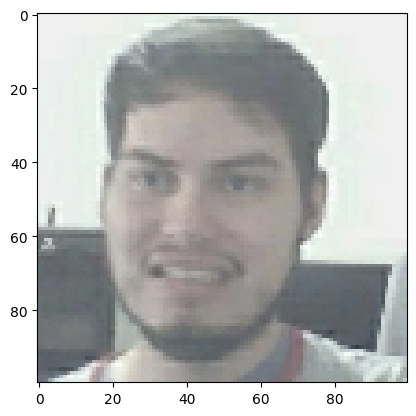

In [34]:
plt.imshow(res[1])

In [35]:
res[2]

1.0

In [36]:
#construir el sitio para cargar los datos
data = data.map(preprocess_etiquetado)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [37]:
#Dividir los datos para entrenamiento
#escoger un lote y prefetch para evitar bottleneck
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [38]:
#Dividir los datos para prueba
#se crea una layer más para especificar el batch
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

- Creación de capa de embedding y de distancia
- Red Neuronal Convolucional Siamesa

In [39]:
def realizar_embedding():
    inp = Input(shape=(100,100,3),name='img_entrada')
    #Filtro de 64, acivacion relu, primer bloque
    conv1 = Conv2D(64, (10,10), activation='relu')(inp)
    mxpl1 = MaxPooling2D(64,(2,2),padding='same')(conv1)
    #Segundo bloque
    conv2 = Conv2D(128, (7,7), activation='relu')(mxpl1)
    mxpl2 = MaxPooling2D(64,(2,2),padding='same')(conv2)
    #Tercer bloque
    conv3 = Conv2D(128, (4,4), activation='relu')(mxpl2)
    mxpl3 = MaxPooling2D(64,(2,2),padding='same')(conv3)
    #Cuarto bloque y último
    conv4 = Conv2D(256, (4,4), activation='relu')(mxpl3)
    #Capa "fully connected"
    flatt = Flatten()(conv4)
    dense = Dense(4096,activation='sigmoid')(flatt)

    return Model(inputs=[inp],outputs=[dense],name='embedding')

In [40]:
embedding = realizar_embedding()

In [41]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_entrada (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

Realizar la capa de distancia

In [6]:
#Capa personalizable para exportar el modelo
#Le pasamos la clase Layer de keras
class L1Dist(Layer):
    # Inicializar método
    def __init__(self, **kwargs):
        super().__init__()

    # Qué hacer cuando se le pasan datos, aquí se combinan las dos
    # redes que al principio estaban separadas
    #se realiza un porcentaje de similitud por así decirlo
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

Definir el modelo de Red Siamesa

In [43]:
def crear_red_siamesa():
    input_image = Input(name='img_entrada', shape=(100,100,3))
    validation_image = Input(name='img_validacion',shape=(100,100,3))
    #combinar los componentes
    capa_siamesa = L1Dist()
    capa_siamesa._name = 'distance'
    distancias = capa_siamesa(embedding(input_image),embedding(validation_image))
    #definimos la capa de salida
    clasificador = Dense(1, activation='sigmoid')(distancias)
    return Model(inputs=[input_image, validation_image],outputs=clasificador,name='RedSiamesa')

In [44]:
red_final = crear_red_siamesa()

Ahora sí, entrenamiento

In [45]:
red_final.summary()

Model: "RedSiamesa"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_entrada (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
img_validacion (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    img_entrada[0][0]                
                                                                 img_validacion[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]         

Ahora sí el entrenamiento

In [46]:
#Crear la pérdida y el optimizador
loss_cross = tf.losses.BinaryCrossentropy()
optimizer_cross = tf.keras.optimizers.Adam(1e-4) #0.0001 de learning rate

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer_cross, siamese_model=red_final)

Construimos la función de entrenamiento por pasos

In [48]:
@tf.function
def train_step(batch):
    #Obtener los gradientes para calcular la diferenciación de las imágenes

    with tf.GradientTape() as tape:
        #Obtener las imagenes de ancla, positiva y negativa
        X = batch[:2]
        #Obtener la etiqueta
        Y = batch[2]
        #Un paso hacia adelante para el entranamiento
        yhat = red_final(X,training=True)
        #Calcular pérdida
        loss = loss_cross(Y, yhat)
    print(loss)
    #Calcular los gradientes
    grad = tape.gradient(loss,red_final.trainable_variables)
    #Calcular los pesos actualizados y aplicarlos al modelo
    optimizer_cross.apply_gradients(zip(grad, red_final.trainable_variables))
    #Retornar la pérdida
    return loss

Creando nuestro propio iterador de entrenamiento

In [4]:
#Importar métricas de cálculo
from tensorflow.keras.metrics import Precision, Recall

In [50]:
def entrenar(data, epocas):
    #Iterar entre las épocas
    for epoch in range(1, epocas+1):
        print('\nEpoca: {}/{}'.format(epoch,epocas))
        progreso = tf.keras.utils.Progbar(len(data))
        #Creando una métrica para cada objeto
        r = Recall()
        p = Precision()
        #Iterar entre cada batch
        for idx, batch in enumerate(data):
            #Aquí se va a entrenar
            loss = train_step(batch)
            yhat = red_final.predict(batch[:2])
            r.update_state(batch[2],yhat)
            p.update_state(batch[2],yhat)
            progreso.update(idx+1)
        print(loss.numpy(),r.result().numpy(),p.result().numpy())
        #Guardar los checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


Entrenando

In [51]:
epocasElegidas = 50
entrenar(train_data, epocasElegidas)



Epoca: 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
263/263 [==============================] - 170s 512ms/step
0.0077645145 0.93904763 0.9964629

Epoca: 2/50
263/263 [==============================] - 138s 524ms/step
0.051946595 0.99007094 0.9990458

Epoca: 3/50
263/263 [==============================] - 135s 514ms/step
0.0006831802 0.98722196 0.99333334

Epoca: 4/50
263/263 [==============================] - 137s 519ms/step
0.016203802 0.9917795 0.9990258

Epoca: 5/50
263/263 [==============================] - 140s 531ms/step
0.00074776786 0.9961796 0.99952084

Epoca: 6/50
263/263 [==============================] - 137s 521ms/step
0.055602156 0.9971537 0.9990494

Epoca: 7/50
263/263 [==============================] - 131s 499ms/step
0.0002360583 0.9995292 1.0

Epoca: 8/50
263/263 [==============================] - 131s 499ms/step
0.06923108 0.99527633 1.0

Epoca: 9/50
263

In [5]:
# Importar métricas para calcular
from tensorflow.keras.metrics import Precision, Recall

In [53]:
# Sacar un lote para validar los datos
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [54]:
y_hat = red_final.predict([test_input, test_val])

In [55]:
# Post resultados
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0]

In [56]:
y_true

array([1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

Calcular métricas

In [57]:
# Crear un recall
m = Recall()

# Calcular los valores de recall
m.update_state(y_true, y_hat)

# Regresar el valor de recall
m.result().numpy()

0.90909094

In [58]:
# Crear una precision
p = Precision()

# Calcular los valores de recall
p.update_state(y_true, y_hat)

# Regresar el valor de recall
p.result().numpy()

1.0

In [59]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = red_final.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

0.9920364 1.0


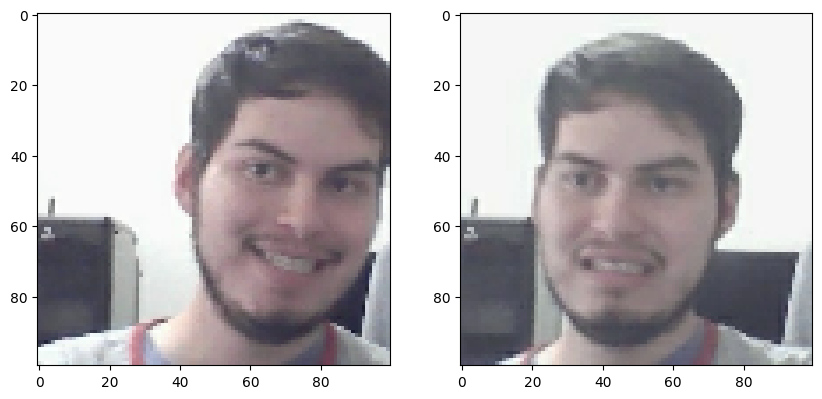

In [60]:
#Visualizar resultados
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Render image
plt.show()

Guardamos el modelo

In [61]:
# Guardar los pesos del modelo
red_final.save('siamesemodelv2.h5')

In [7]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [8]:
def verify(model, detection_threshold, verification_threshold):
    # Resultados para ver
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Realizar predicciones
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Métrica para considerar que una clase es positiva
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verificar la proporción de positivos y negativos
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [11]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
False
False
False
True
True
True
False
True
False
False
False
False
False
False


In [12]:
np.squeeze(results) > 0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])